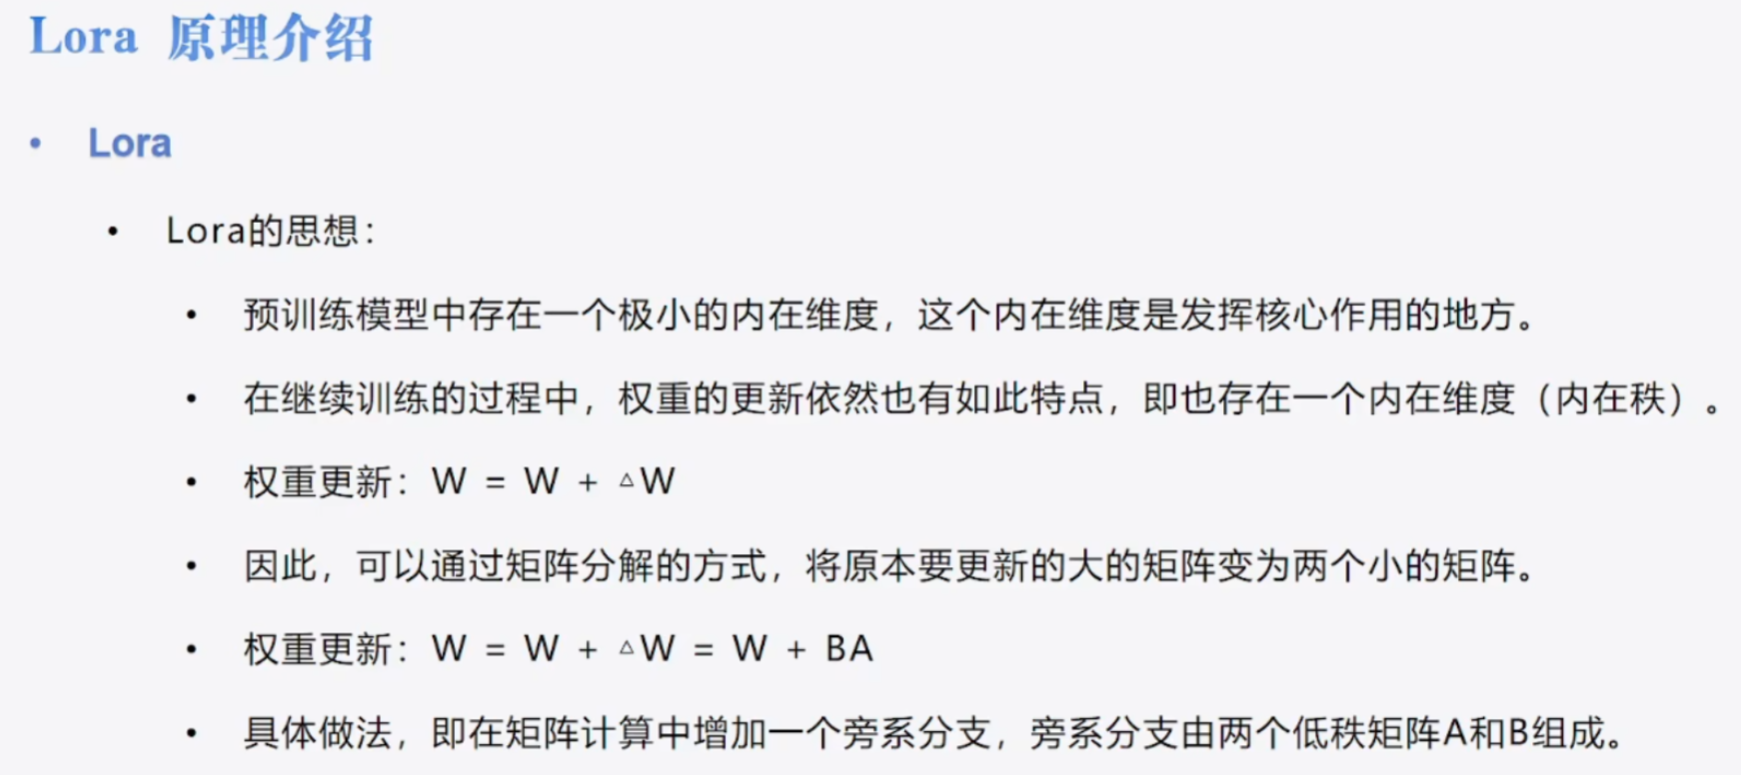

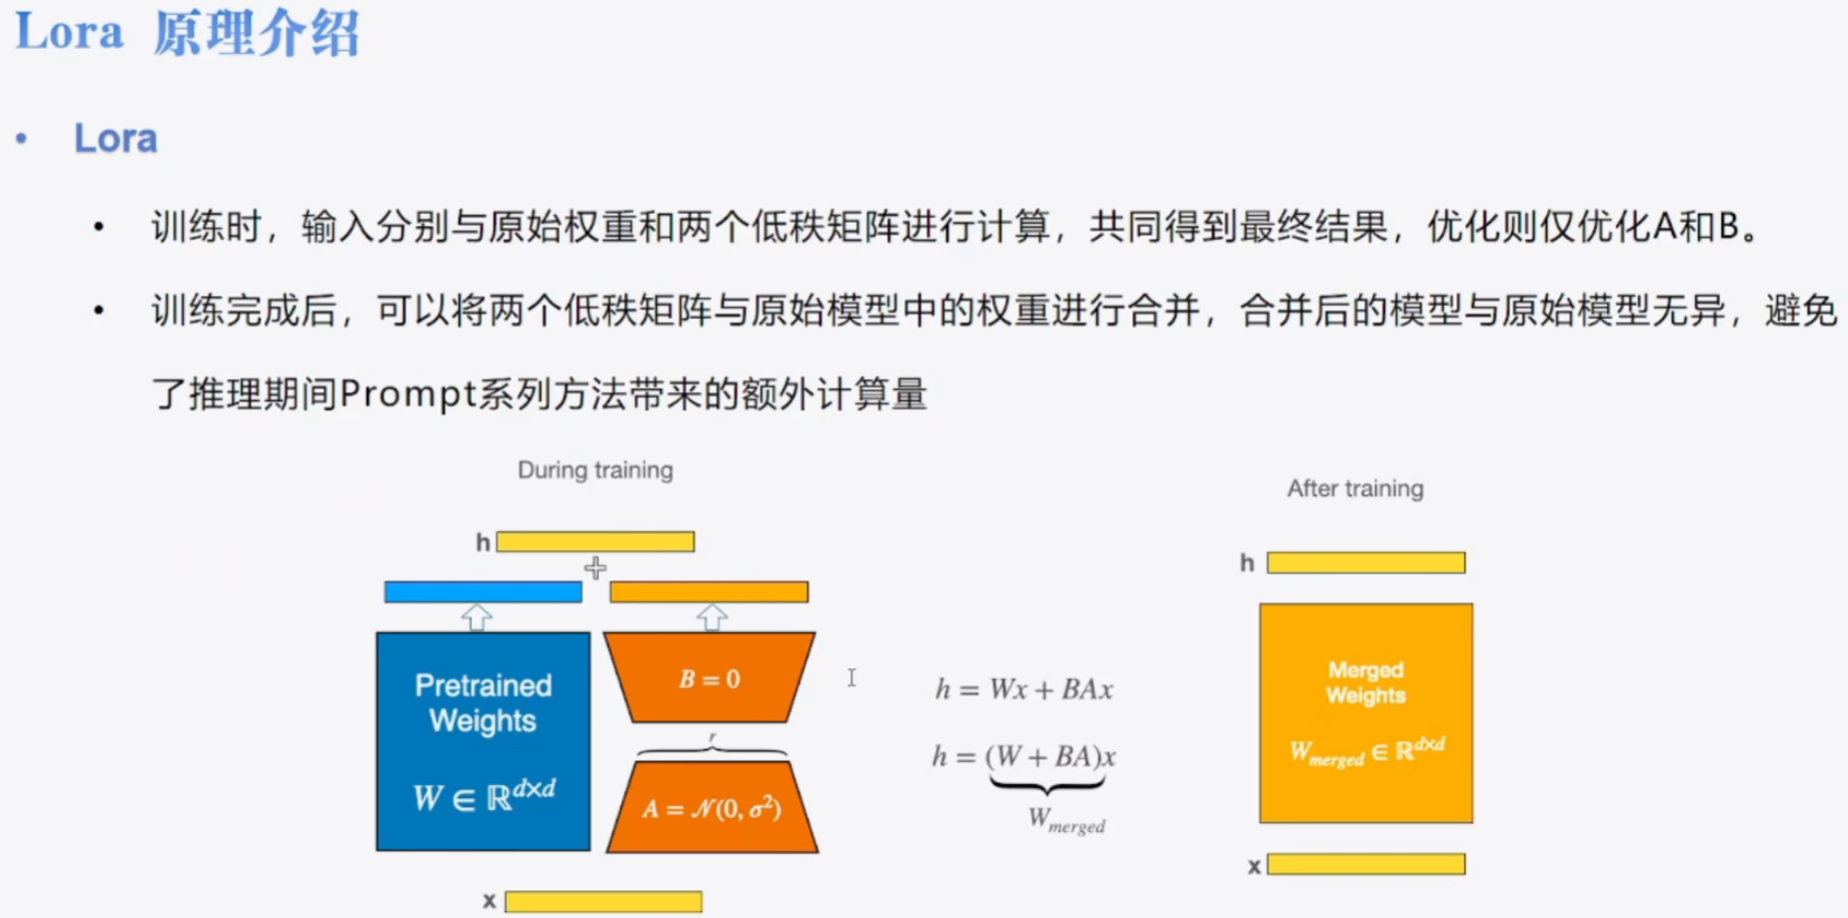

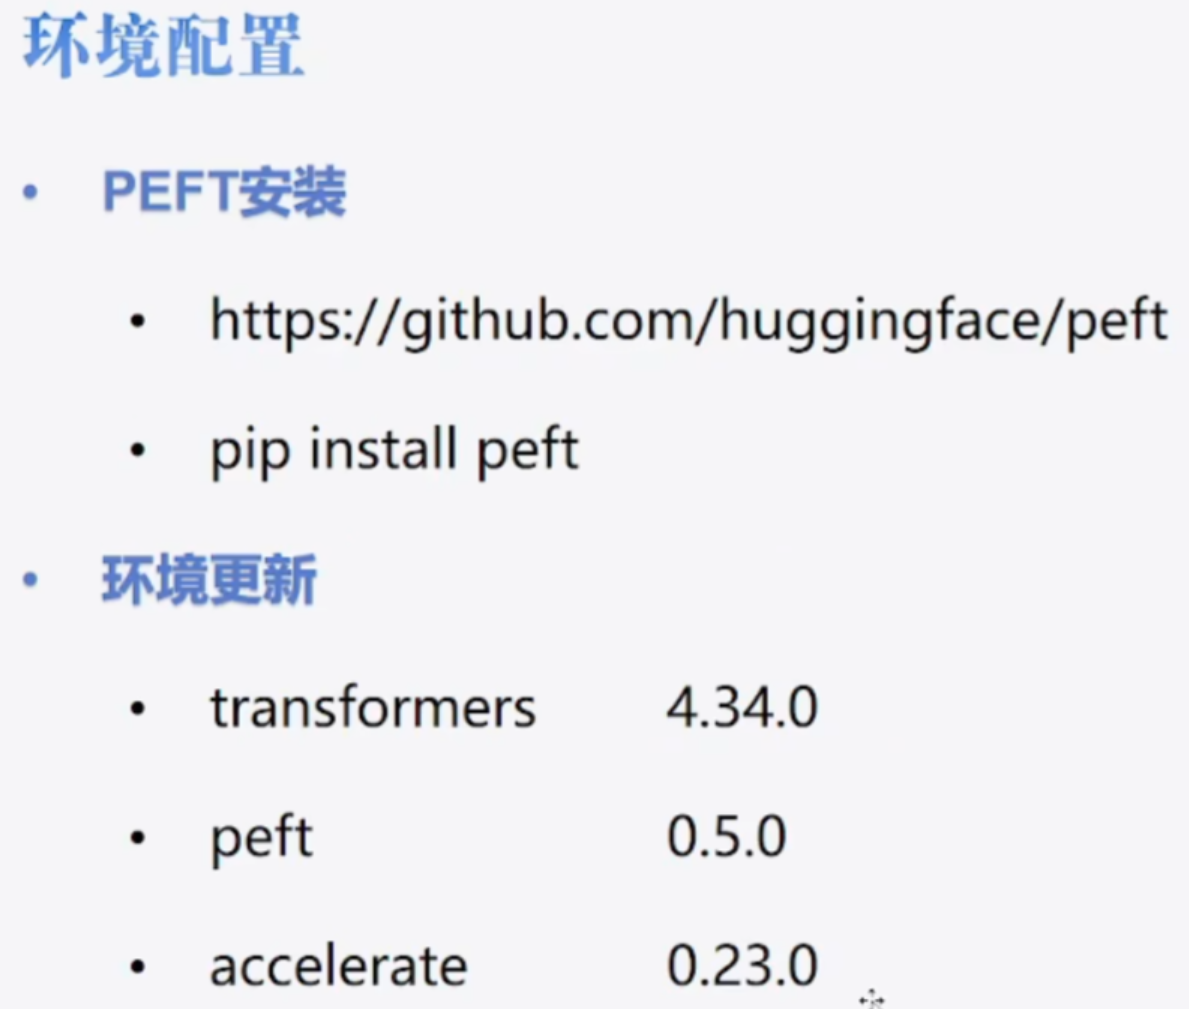

In [1]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [2]:
ds = Dataset.load_from_disk("./alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [5]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [6]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh", low_cpu_mem_usage=True)

In [17]:
for name,param in model.named_parameters():
    print(name)

base_model.model.transformer.word_embeddings.weight
base_model.model.transformer.word_embeddings_layernorm.weight
base_model.model.transformer.word_embeddings_layernorm.bias
base_model.model.transformer.h.0.input_layernorm.weight
base_model.model.transformer.h.0.input_layernorm.bias
base_model.model.transformer.h.0.self_attention.query_key_value.base_layer.weight
base_model.model.transformer.h.0.self_attention.query_key_value.base_layer.bias
base_model.model.transformer.h.0.self_attention.query_key_value.lora_A.default.weight
base_model.model.transformer.h.0.self_attention.query_key_value.lora_B.default.weight
base_model.model.transformer.h.0.self_attention.dense.weight
base_model.model.transformer.h.0.self_attention.dense.bias
base_model.model.transformer.h.0.post_attention_layernorm.weight
base_model.model.transformer.h.0.post_attention_layernorm.bias
base_model.model.transformer.h.0.mlp.dense_h_to_4h.weight
base_model.model.transformer.h.0.mlp.dense_h_to_4h.bias
base_model.model.tra

: 

# Lora

### Step1 配置文件

In [7]:
from peft import LoraConfig, TaskType, get_peft_model
# prefix_projection=False 默认为True，设置为False可以减少计算量,prefix_projection 通常是在配置提示学习的过程中会用到的一个布尔类型参数，常见于如 PrefixTuningConfig 这类配置类里。它决定了是否使用投影层（projection layer）来对前缀提示（prefix prompt）进行处理。

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, r=8, target_modules=None, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [ ]:
# task type的作用是：1. 确定lora的task type，2. 确定lora的target modules，3. 确定需要保存的modules。
# target_modules: 指定需要微调的模块，例如"query_key_value"表示需要微调query和key的参数。
# modules_to_save: 指定需要保存的模块，例如"word_embeddings"表示需要保存词嵌入层的参数。
config = LoraConfig(task_type=TaskType.CAUSAL_LM, target_modules=["query_key_value"], modules_to_save=["word_embeddings"])
config

### Step2 创建模型

In [8]:
model=get_peft_model(model,config)

In [9]:
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='Langboat/bloom-1b4-zh', revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, r=8, target_modules={'query_key_value'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [10]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(46145, 2048)
        (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=6144, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=6144, bias=False)
                )
                (lora_embedding_A): Paramete

------------

In [13]:
args = TrainingArguments(
    output_dir="./lora-tuning",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

In [14]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

In [15]:
trainer.train()

  0%|          | 0/3357 [00:00<?, ?it/s]

{'loss': 2.9997, 'grad_norm': 0.5374448299407959, 'learning_rate': 4.985105749180816e-05, 'epoch': 0.0}
{'loss': 3.1486, 'grad_norm': 0.5468236207962036, 'learning_rate': 4.9702114983616324e-05, 'epoch': 0.01}
{'loss': 2.9285, 'grad_norm': 0.5598716735839844, 'learning_rate': 4.9553172475424484e-05, 'epoch': 0.01}
{'loss': 2.8454, 'grad_norm': 0.8940125107765198, 'learning_rate': 4.940422996723265e-05, 'epoch': 0.01}
{'loss': 2.7946, 'grad_norm': 0.882594645023346, 'learning_rate': 4.925528745904081e-05, 'epoch': 0.01}
{'loss': 2.8216, 'grad_norm': 0.812590479850769, 'learning_rate': 4.910634495084897e-05, 'epoch': 0.02}
{'loss': 2.5959, 'grad_norm': 0.9291679859161377, 'learning_rate': 4.895740244265713e-05, 'epoch': 0.02}
{'loss': 2.5684, 'grad_norm': 0.6740489602088928, 'learning_rate': 4.88084599344653e-05, 'epoch': 0.02}
{'loss': 2.4816, 'grad_norm': 1.369602084159851, 'learning_rate': 4.865951742627346e-05, 'epoch': 0.03}
{'loss': 2.4217, 'grad_norm': 0.6751847863197327, 'learnin

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.2677, 'grad_norm': 1.696887731552124, 'learning_rate': 4.240393208221627e-05, 'epoch': 0.15}
{'loss': 2.5092, 'grad_norm': 1.322601079940796, 'learning_rate': 4.225498957402443e-05, 'epoch': 0.15}
{'loss': 2.3187, 'grad_norm': 2.270456075668335, 'learning_rate': 4.2106047065832595e-05, 'epoch': 0.16}
{'loss': 2.3452, 'grad_norm': 2.2557921409606934, 'learning_rate': 4.1957104557640756e-05, 'epoch': 0.16}
{'loss': 2.3295, 'grad_norm': 1.4824213981628418, 'learning_rate': 4.180816204944891e-05, 'epoch': 0.16}
{'loss': 2.2701, 'grad_norm': 2.325565814971924, 'learning_rate': 4.165921954125708e-05, 'epoch': 0.17}
{'loss': 2.3507, 'grad_norm': 1.1537482738494873, 'learning_rate': 4.151027703306524e-05, 'epoch': 0.17}
{'loss': 2.421, 'grad_norm': 4.284370422363281, 'learning_rate': 4.1361334524873405e-05, 'epoch': 0.17}
{'loss': 2.2707, 'grad_norm': 1.2163081169128418, 'learning_rate': 4.121239201668156e-05, 'epoch': 0.18}
{'loss': 2.2635, 'grad_norm': 2.2655558586120605, 'learnin

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.207, 'grad_norm': 1.9094641208648682, 'learning_rate': 3.495680667262437e-05, 'epoch': 0.3}
{'loss': 2.2604, 'grad_norm': 1.8896037340164185, 'learning_rate': 3.480786416443253e-05, 'epoch': 0.3}
{'loss': 2.293, 'grad_norm': 1.2774134874343872, 'learning_rate': 3.465892165624069e-05, 'epoch': 0.31}
{'loss': 2.2793, 'grad_norm': 1.4820680618286133, 'learning_rate': 3.450997914804885e-05, 'epoch': 0.31}
{'loss': 2.1436, 'grad_norm': 2.343912363052368, 'learning_rate': 3.436103663985702e-05, 'epoch': 0.31}
{'loss': 2.3035, 'grad_norm': 1.654405951499939, 'learning_rate': 3.421209413166518e-05, 'epoch': 0.32}
{'loss': 2.2519, 'grad_norm': 5.407580852508545, 'learning_rate': 3.406315162347334e-05, 'epoch': 0.32}
{'loss': 2.4133, 'grad_norm': 1.7907612323760986, 'learning_rate': 3.39142091152815e-05, 'epoch': 0.32}
{'loss': 2.201, 'grad_norm': 5.046934127807617, 'learning_rate': 3.376526660708966e-05, 'epoch': 0.32}
{'loss': 2.1373, 'grad_norm': 1.5503206253051758, 'learning_rate'

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.2826, 'grad_norm': 2.2675540447235107, 'learning_rate': 2.750968126303247e-05, 'epoch': 0.45}
{'loss': 2.2599, 'grad_norm': 2.1961758136749268, 'learning_rate': 2.7360738754840632e-05, 'epoch': 0.45}
{'loss': 2.3782, 'grad_norm': 1.2810062170028687, 'learning_rate': 2.7211796246648796e-05, 'epoch': 0.46}
{'loss': 2.28, 'grad_norm': 1.5244852304458618, 'learning_rate': 2.7062853738456957e-05, 'epoch': 0.46}
{'loss': 2.3576, 'grad_norm': 2.471383810043335, 'learning_rate': 2.691391123026512e-05, 'epoch': 0.46}
{'loss': 2.2402, 'grad_norm': 1.0257651805877686, 'learning_rate': 2.676496872207328e-05, 'epoch': 0.46}
{'loss': 2.1376, 'grad_norm': 2.016505479812622, 'learning_rate': 2.6616026213881445e-05, 'epoch': 0.47}
{'loss': 2.05, 'grad_norm': 1.8231409788131714, 'learning_rate': 2.6467083705689606e-05, 'epoch': 0.47}
{'loss': 2.174, 'grad_norm': 1.609235167503357, 'learning_rate': 2.631814119749777e-05, 'epoch': 0.47}
{'loss': 2.3094, 'grad_norm': 1.670459508895874, 'learning

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.1719, 'grad_norm': 3.565847635269165, 'learning_rate': 2.0062555853440572e-05, 'epoch': 0.6}
{'loss': 2.161, 'grad_norm': 2.2568275928497314, 'learning_rate': 1.9913613345248736e-05, 'epoch': 0.6}
{'loss': 2.2813, 'grad_norm': 1.5994950532913208, 'learning_rate': 1.9764670837056897e-05, 'epoch': 0.6}
{'loss': 2.103, 'grad_norm': 1.319718599319458, 'learning_rate': 1.961572832886506e-05, 'epoch': 0.61}
{'loss': 2.3016, 'grad_norm': 1.816939353942871, 'learning_rate': 1.946678582067322e-05, 'epoch': 0.61}
{'loss': 2.2211, 'grad_norm': 2.6871402263641357, 'learning_rate': 1.9317843312481382e-05, 'epoch': 0.61}
{'loss': 2.0684, 'grad_norm': 1.9362825155258179, 'learning_rate': 1.9168900804289542e-05, 'epoch': 0.62}
{'loss': 2.1648, 'grad_norm': 2.0088210105895996, 'learning_rate': 1.9019958296097706e-05, 'epoch': 0.62}
{'loss': 2.1389, 'grad_norm': 1.8271018266677856, 'learning_rate': 1.8871015787905867e-05, 'epoch': 0.62}
{'loss': 2.194, 'grad_norm': 2.1482315063476562, 'learni

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.1951, 'grad_norm': 6.026002883911133, 'learning_rate': 1.2615430443848674e-05, 'epoch': 0.75}
{'loss': 2.1696, 'grad_norm': 3.8837831020355225, 'learning_rate': 1.2466487935656837e-05, 'epoch': 0.75}
{'loss': 2.2712, 'grad_norm': 3.6751203536987305, 'learning_rate': 1.2317545427464999e-05, 'epoch': 0.75}
{'loss': 2.2634, 'grad_norm': 2.232358455657959, 'learning_rate': 1.2168602919273161e-05, 'epoch': 0.76}
{'loss': 2.1616, 'grad_norm': 2.157228469848633, 'learning_rate': 1.2019660411081324e-05, 'epoch': 0.76}
{'loss': 2.1683, 'grad_norm': 1.750095248222351, 'learning_rate': 1.1870717902889484e-05, 'epoch': 0.76}
{'loss': 2.2104, 'grad_norm': 7.077750205993652, 'learning_rate': 1.1721775394697646e-05, 'epoch': 0.77}
{'loss': 2.3277, 'grad_norm': 2.3732616901397705, 'learning_rate': 1.1572832886505809e-05, 'epoch': 0.77}
{'loss': 2.3548, 'grad_norm': 4.972410202026367, 'learning_rate': 1.1423890378313971e-05, 'epoch': 0.77}
{'loss': 2.2643, 'grad_norm': 3.14864444732666, 'lea

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.1785, 'grad_norm': 1.7742884159088135, 'learning_rate': 5.168305034256777e-06, 'epoch': 0.9}
{'loss': 2.208, 'grad_norm': 3.366758108139038, 'learning_rate': 5.019362526064939e-06, 'epoch': 0.9}
{'loss': 2.2441, 'grad_norm': 3.4368691444396973, 'learning_rate': 4.870420017873101e-06, 'epoch': 0.9}
{'loss': 2.1394, 'grad_norm': 2.5018298625946045, 'learning_rate': 4.721477509681263e-06, 'epoch': 0.91}
{'loss': 2.2549, 'grad_norm': 2.4427385330200195, 'learning_rate': 4.572535001489425e-06, 'epoch': 0.91}
{'loss': 2.1963, 'grad_norm': 1.9545854330062866, 'learning_rate': 4.423592493297587e-06, 'epoch': 0.91}
{'loss': 2.3279, 'grad_norm': 1.3692102432250977, 'learning_rate': 4.274649985105749e-06, 'epoch': 0.91}
{'loss': 2.2572, 'grad_norm': 1.5412567853927612, 'learning_rate': 4.125707476913911e-06, 'epoch': 0.92}
{'loss': 2.293, 'grad_norm': 1.911312222480774, 'learning_rate': 3.976764968722073e-06, 'epoch': 0.92}
{'loss': 2.1381, 'grad_norm': 1.885084629058838, 'learning_rat

TrainOutput(global_step=3357, training_loss=2.2729110410961324, metrics={'train_runtime': 2946.6584, 'train_samples_per_second': 9.115, 'train_steps_per_second': 1.139, 'total_flos': 1.4783328704741376e+16, 'train_loss': 2.2729110410961324, 'epoch': 0.9999255342914588})

In [14]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 考试有哪些技巧？
在考试时，除了注意以下事项，在心理状态上，不要太紧张太紧张。
首先，应避免被焦虑感所纠缠。在考试前，不要太紧张太紧张。但一定要做好心理准备。
其次，要注意放松。放松是保持良好心态的关键要素，并且，放松也是增强压力的关键要素。在考试过程中，要做好心理准备。同时，在心理上保持放松可以让自己更加平静。在心理上保持放松可以有利于保持最佳心理状态。在心理上保持放松还可以维持


In [17]:
from peft import PeftModel
peft_model = PeftModel.from_pretrained(model, "./prefix-tuning/checkpoint-500")
peft_model  

PeftModelForCausalLM(
  (base_model): PeftModelForCausalLM(
    (base_model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(46145, 2048)
        (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
              (dense): Linear(in_features=2048, out_features=2048, bias=True)
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (mlp): BloomMLP(
              (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
              (gelu_impl): BloomGelu()
              (dense_4h_to_h): Linear(in_fe

In [18]:
peft_model = peft_model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 免得
Comment: 免得
Comment: 免得
Comment: 免得
Comment: 免得


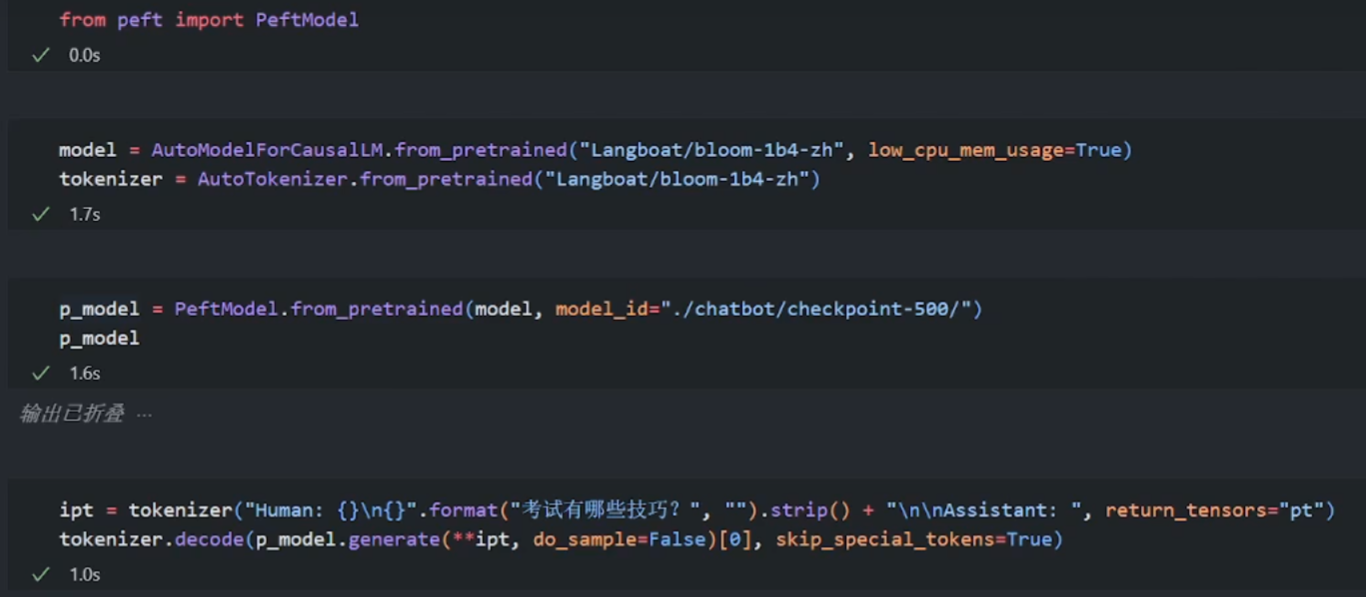